# Botryllus brain analysis1
By: Atefe Rostami

# Packages

In [1]:
import warnings
import random
warnings.simplefilter(action = "ignore", category = FutureWarning)
import numpy as np
import pandas as pd
# import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from igraph import *
import csv
from igraph import *
# from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
from anndata import read_h5ad
from anndata import read_text
# import bbknn
# import leidenalg
import seaborn as sns
#from gprofiler import GProfiler

from anndata import AnnData

import plotly.graph_objects as go
import plotly.offline as pyo


In [2]:
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", mpl.__version__)
print("seaborn version:", sns.__version__)


numpy version: 2.2.6
pandas version: 2.2.3
matplotlib version: 3.10.3
seaborn version: 0.13.2


In [3]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Initial data import


In [4]:
# Load the dataset
file_path = "ci_brain_dec2023_counts_brain.txt" # Update if needed
df = pd.read_csv(file_path, sep="\t")

# Pre_Processing

In [5]:
main_columns = [col for col in df.columns if col not in ["V1", "V2"]]

new_column_names = []
for col in main_columns:
    parts = col.split("_")  # Splitting by "_"

    try:
        sample_id = parts[3]  # ILWXYZ (Sample ID)
        region = parts[5]  # Region (B2, AB)

        # Ensure "19_months" is not split
        if parts[12].isdigit() and parts[13] == "months":
            age = f"{parts[12]}_{parts[13]}"  # "19_months"
            replicate = parts[9]  # Replicate (pXXcXXrXX)
            sample_number = parts[14]  # Sample Number (SXXX)
        else:
            age = "Unknown"  # If structure doesn't match, label as unknown
            replicate = parts[-4] if len(parts) > 4 else "Unknown"
            sample_number = parts[-3] if len(parts) > 3 else "Unknown"

        # Construct the new column name in the expected format
        new_col_name = f"{sample_id}-{region}-{age}-{replicate}-{sample_number}"
    except IndexError:
        new_col_name = col  # Keep original if unexpected format

    new_column_names.append(new_col_name)

# Rename columns in DataFrame
df.columns = ["Gene_ID", "Gene_Name"] + new_column_names
display(df.head())

,Gene_ID,Gene_Name,ILW100-B2-19_months-p05c01r01-S385,ILW100-B2-19_months-p05c05r02-S401,ILW100-B2-19_months-p05c09r03-S417,ILW100-B2-19_months-p05c01r05-S433,ILW100-B2-19_months-p05c05r06-S449,ILW100-B2-19_months-p05c09r07-S465,ILW101-B2-19_months-p06c01r01-S481,ILW101-B2-19_months-p06c05r02-S497,...,ILW105-AB-19_months-p10c12r04-S912,ILW106-AB-19_months-p10c04r06-S928,ILW106-AB-19_months-p10c08r07-S944,ILW106-AB-19_months-p10c12r08-S960,ILW106-AB-19_months-p11c04r02-S976,ILW106-AB-19_months-p11c08r03-S992,ILW106-AB-19_months-p11c12r04-S1008,ILW107-AB-19_months-p11c04r06-S1024,ILW107-AB-19_months-p11c08r07-S1040,ILW107-AB-19_months-p11c12r08-S1056
0,FUN_000001,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,FUN_000002,DNAJB11_1,0,0,0,0,0,0,0,0,...,0,0,0,16,0,0,0,0,0,0
2,FUN_000003,NaN,0,0,0,0,0,0,0,0,...,0,0,0,3,10,0,0,0,0,0
3,FUN_000004,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,FUN_000005,SMU1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Filename Structure Reference

 Key Components:
 
- **Plate**: `PAC4_PlateX` (e.g., PAC4_Plate1, PAC4_Plate2)
- **Well**: `A01`, `B02`, `C03`, ... (Position in the plate)
- **Sample ID**: `ILWXYZ` (Unique identifier for the sample)
- **Tissue**: `Brain`
- **Tipe of cell (in time)**: `B2`, `AB` (Specific brain region)
- **Cell Size**: `small`, `large`
- **Replicate**: `pXXcXXrXX` (Pattern: plateX_cellX_repX)
- **Age**: `19_months` (or other time points)
- **Sample Number**: `SXXX` (e.g., S101, S202)
- **File Type**: `.bam.counts` (Processed count file)



sampleid- region- age-replicate-sample number

## Detecting duplications


In [6]:
# Count NaN values in the 'Gene_ID' column
nan_count = df['Gene_ID'].isna().sum()

print(f"Number of NaN values in 'Gene_ID': {nan_count}")

# Count NaN values in the 'Gene_ID' column
nan_count = df['Gene_Name'].isna().sum()

print(f"Number of NaN values in 'Gene_Name': {nan_count/df.shape[0]}")
# Check for duplicate Gene_IDs
gi_duplicates = df['Gene_ID'].duplicated().any()
gene_name_duplicates = df['Gene_Name'].duplicated().any()
print(f"Duplicate values in 'Gene_ID': {gi_duplicates}")
print(f"Duplicate values in 'Gene_Name': {gene_name_duplicates}")
# Create a mapping from old Gene_ID to new format
df = df.iloc[:-5]
df['Gene_ID'] = df['Gene_ID'].str.extract(r'(\d+)').astype(str)  # Extract numbers
df['Gene_ID'] = 'g' + df['Gene_ID'].astype(str)  # Convert to 'g1', 'g2', etc.
df['Gene_ID'] = df['Gene_ID'].str.replace(r'g0*', 'g', regex=True)
df['Gene_Name'].fillna(df['Gene_ID'], inplace=True)
df["g_unique"] = df["Gene_ID"] + "_" + df["Gene_Name"]
first_col = df.pop('g_unique')  # Remove the column and store it
df.insert(0, 'g_unique', first_col)

display(df.head(3))

# set GI as index
df.set_index('Gene_ID', inplace=True)
# remove "GI", the name of the index
df.index.name = None

# remove the rows which index does not start with "g" (eg. "g1")
df_cleaned = df[df.index.str.startswith('g')]
print(df.shape, df_cleaned.shape)

display(df_cleaned.head())

# save a new df without Gene_Note and Gene_Name columns
df_sel = df_cleaned.drop(['Gene_Name'], axis=1)

df_sel.set_index('g_unique', inplace=True)
df_sel.index.name = None

df_sel.head()



Number of NaN values in 'Gene_ID': 0
Number of NaN values in 'Gene_Name': 0.7462666547438076
Duplicate values in 'Gene_ID': False
Duplicate values in 'Gene_Name': True


,g_unique,Gene_ID,Gene_Name,ILW100-B2-19_months-p05c01r01-S385,ILW100-B2-19_months-p05c05r02-S401,ILW100-B2-19_months-p05c09r03-S417,ILW100-B2-19_months-p05c01r05-S433,ILW100-B2-19_months-p05c05r06-S449,ILW100-B2-19_months-p05c09r07-S465,ILW101-B2-19_months-p06c01r01-S481,...,ILW105-AB-19_months-p10c12r04-S912,ILW106-AB-19_months-p10c04r06-S928,ILW106-AB-19_months-p10c08r07-S944,ILW106-AB-19_months-p10c12r08-S960,ILW106-AB-19_months-p11c04r02-S976,ILW106-AB-19_months-p11c08r03-S992,ILW106-AB-19_months-p11c12r04-S1008,ILW107-AB-19_months-p11c04r06-S1024,ILW107-AB-19_months-p11c08r07-S1040,ILW107-AB-19_months-p11c12r08-S1056
0,g1_g1,g1,g1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,g2_DNAJB11_1,g2,DNAJB11_1,0,0,0,0,0,0,0,...,0,0,0,16,0,0,0,0,0,0
2,g3_g3,g3,g3,0,0,0,0,0,0,0,...,0,0,0,3,10,0,0,0,0,0


(44727, 685) (44727, 685)


,g_unique,Gene_Name,ILW100-B2-19_months-p05c01r01-S385,ILW100-B2-19_months-p05c05r02-S401,ILW100-B2-19_months-p05c09r03-S417,ILW100-B2-19_months-p05c01r05-S433,ILW100-B2-19_months-p05c05r06-S449,ILW100-B2-19_months-p05c09r07-S465,ILW101-B2-19_months-p06c01r01-S481,ILW101-B2-19_months-p06c05r02-S497,...,ILW105-AB-19_months-p10c12r04-S912,ILW106-AB-19_months-p10c04r06-S928,ILW106-AB-19_months-p10c08r07-S944,ILW106-AB-19_months-p10c12r08-S960,ILW106-AB-19_months-p11c04r02-S976,ILW106-AB-19_months-p11c08r03-S992,ILW106-AB-19_months-p11c12r04-S1008,ILW107-AB-19_months-p11c04r06-S1024,ILW107-AB-19_months-p11c08r07-S1040,ILW107-AB-19_months-p11c12r08-S1056
g1,g1_g1,g1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g2,g2_DNAJB11_1,DNAJB11_1,0,0,0,0,0,0,0,0,...,0,0,0,16,0,0,0,0,0,0
g3,g3_g3,g3,0,0,0,0,0,0,0,0,...,0,0,0,3,10,0,0,0,0,0
g4,g4_g4,g4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g5,g5_SMU1,SMU1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,ILW100-B2-19_months-p05c01r01-S385,ILW100-B2-19_months-p05c05r02-S401,ILW100-B2-19_months-p05c09r03-S417,ILW100-B2-19_months-p05c01r05-S433,ILW100-B2-19_months-p05c05r06-S449,ILW100-B2-19_months-p05c09r07-S465,ILW101-B2-19_months-p06c01r01-S481,ILW101-B2-19_months-p06c05r02-S497,ILW101-B2-19_months-p06c09r03-S513,ILW101-B2-19_months-p06c01r05-S529,...,ILW105-AB-19_months-p10c12r04-S912,ILW106-AB-19_months-p10c04r06-S928,ILW106-AB-19_months-p10c08r07-S944,ILW106-AB-19_months-p10c12r08-S960,ILW106-AB-19_months-p11c04r02-S976,ILW106-AB-19_months-p11c08r03-S992,ILW106-AB-19_months-p11c12r04-S1008,ILW107-AB-19_months-p11c04r06-S1024,ILW107-AB-19_months-p11c08r07-S1040,ILW107-AB-19_months-p11c12r08-S1056
g1_g1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g2_DNAJB11_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,16,0,0,0,0,0,0
g3_g3,0,0,0,0,0,0,0,0,0,3,...,0,0,0,3,10,0,0,0,0,0
g4_g4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g5_SMU1,0,0,0,0,0,0,0,0,9,0,...,0,0,0,0,0,0,0,0,0,0


**df_sel** is the cleaned input dataset. Ready for more processing

## AnnData

In [7]:
# adata = AnnData(df_sel)
# Transpose the DataFrame to have genes as rows and cells as columns
# obs is the cell/sample IDs
# var is the gene IDs/names
adata = AnnData(X=df_sel.T.values, obs=pd.DataFrame(index=df_sel.columns), var=pd.DataFrame(index=df_sel.index))

# print first 4 row names and first 4 column names
print(adata.obs_names[:4])  # First 4 cell/sample IDs
print(adata.var_names[:4])  # First 4 gene IDs/names
print(adata.shape)          # Shape: (cells, genes)


Index(['ILW100-B2-19_months-p05c01r01-S385',
       'ILW100-B2-19_months-p05c05r02-S401',
       'ILW100-B2-19_months-p05c09r03-S417',
       'ILW100-B2-19_months-p05c01r05-S433'],
      dtype='object')
Index(['g1_g1', 'g2_DNAJB11_1', 'g3_g3', 'g4_g4'], dtype='object')
(683, 44727)


In [8]:
import scipy.sparse

print(type(adata.X))

# Or check if it's sparse
if scipy.sparse.issparse(adata.X):
    print("adata.X is a sparse matrix.")
else:
    print("adata.X is a dense NumPy array.")


<class 'numpy.ndarray'>
adata.X is a dense NumPy array.


adata.X is your expression matrix (cells × genes).

.sum(axis=1) sums counts across all genes for each cell, giving the total counts per cell.


In [9]:
# Parse sample metadata from cell/sample names and store as separate columns in adata.obs
# Extracts Sample_ID, Region, Age, Replicate, and Sample_Number from the sample name string
adata.obs['Sample_ID'] = [i.split('-')[0] for i in adata.obs_names] 
adata.obs['Region'] =    [i.split('-')[1] for i in adata.obs_names]
adata.obs['Age'] =       [i.split('-')[2] for i in adata.obs_names]
adata.obs['Replicate'] = [i.split('-')[3] for i in adata.obs_names]
adata.obs['Sample_Number'] = [i.split('-')[4] for i in adata.obs_names]

print(adata.shape)


(683, 44727)


**Check** the format of the matrix

In [10]:
# Sum along the columns (genes)
# adata.X is a sparse matrix, so we need to convert it to a dense format first
total_counts = adata.X.sum(axis=1)
print(total_counts.shape)

(683,)


## Quality control

In [11]:
import scanpy as sc 
adata.obs['n_counts'] = adata.X.sum(1) # total counts per cell
adata.obs['n_genes'] = (adata.X > 0).sum(1) # number of expressed genes per cell
adata = adata[adata.obs['n_counts']>=100]
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=10)
adata_qc = adata[adata.obs.n_counts >= 100, :].copy()  # Keep your 581 cells
adata_qc = adata_qc[:, adata_qc.var.n_cells >= 10].copy()  # Keep your 14,658 genes


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:170: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



In [12]:
print(adata_qc.shape)

(581, 14658)


# Normalization

## LogNorm

It adjusts for sequencing depth differences across cells — like converting all cells to the same "library size."

Think of it like converting raw counts to counts per 10,000 (CP10K), similar to CPM (counts per million).

In [13]:
sc.pp.normalize_total(adata_qc, target_sum=1e4)
sc.pp.log1p(adata_qc)

# PCA

In [14]:
sc.pp.highly_variable_genes(adata_qc, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_qc.raw = adata_qc
adata_qc = adata_qc[:, adata_qc.var.highly_variable]

In [15]:
# print adata_qc shape
print(f"adata_qc shape: {adata_qc.shape}")

adata_qc shape: (581, 4146)


In [16]:
sc.pp.scale(adata_qc, max_value=10)
sc.tl.pca(adata_qc, svd_solver='arpack')


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning:

Received a view of an AnnData. Making a copy.



In [17]:
print(adata_qc.shape)

(581, 4146)


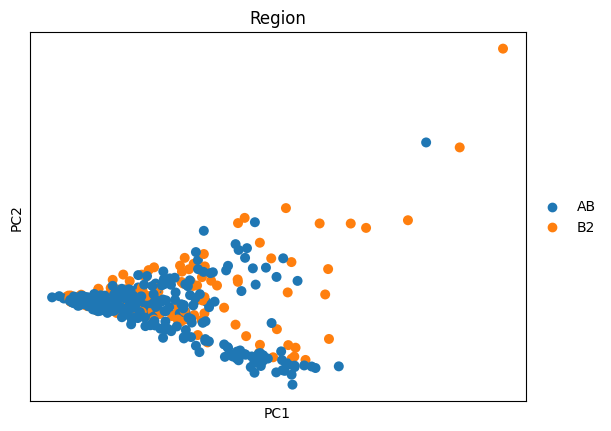

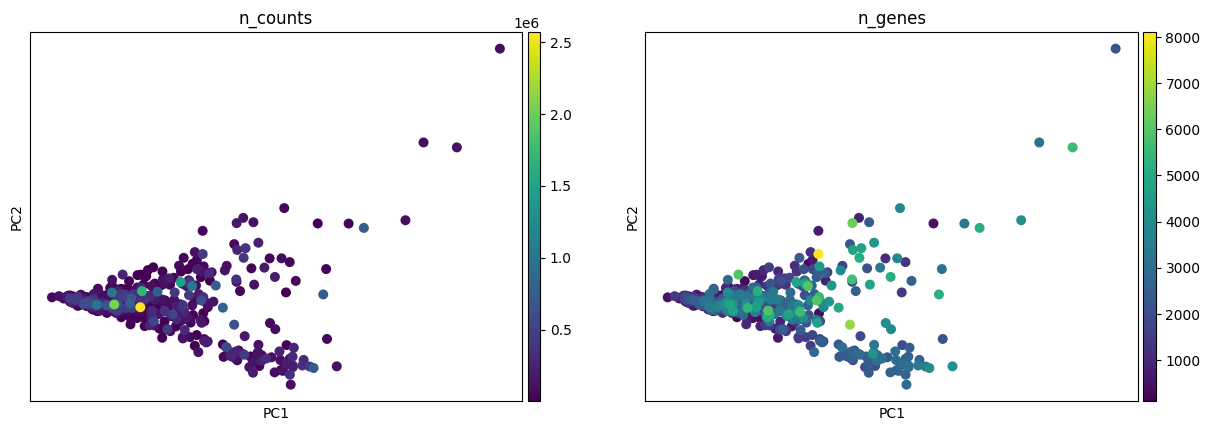

In [18]:
sc.pl.pca(adata_qc, color=['Region'])

# Plot PCA with n_counts and n_genes
sc.pl.pca_scatter(adata_qc, color=['n_counts', 'n_genes'])

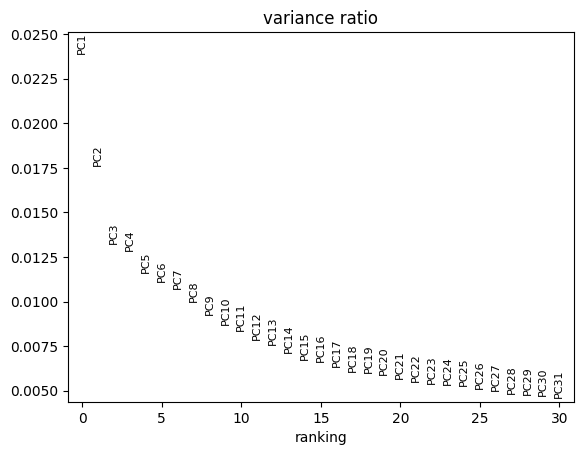

In [19]:
# pca variance ratio
sc.pl.pca_variance_ratio(adata_qc, log=False)



/tmp/ipykernel_166441/2878490838.py:22: DeprecationWarning:

Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)



=== Optimal PC Number Selection ===
Knee point method: PC12
Variance threshold method (1%): PC8
Cumulative variance method (80%): PC50


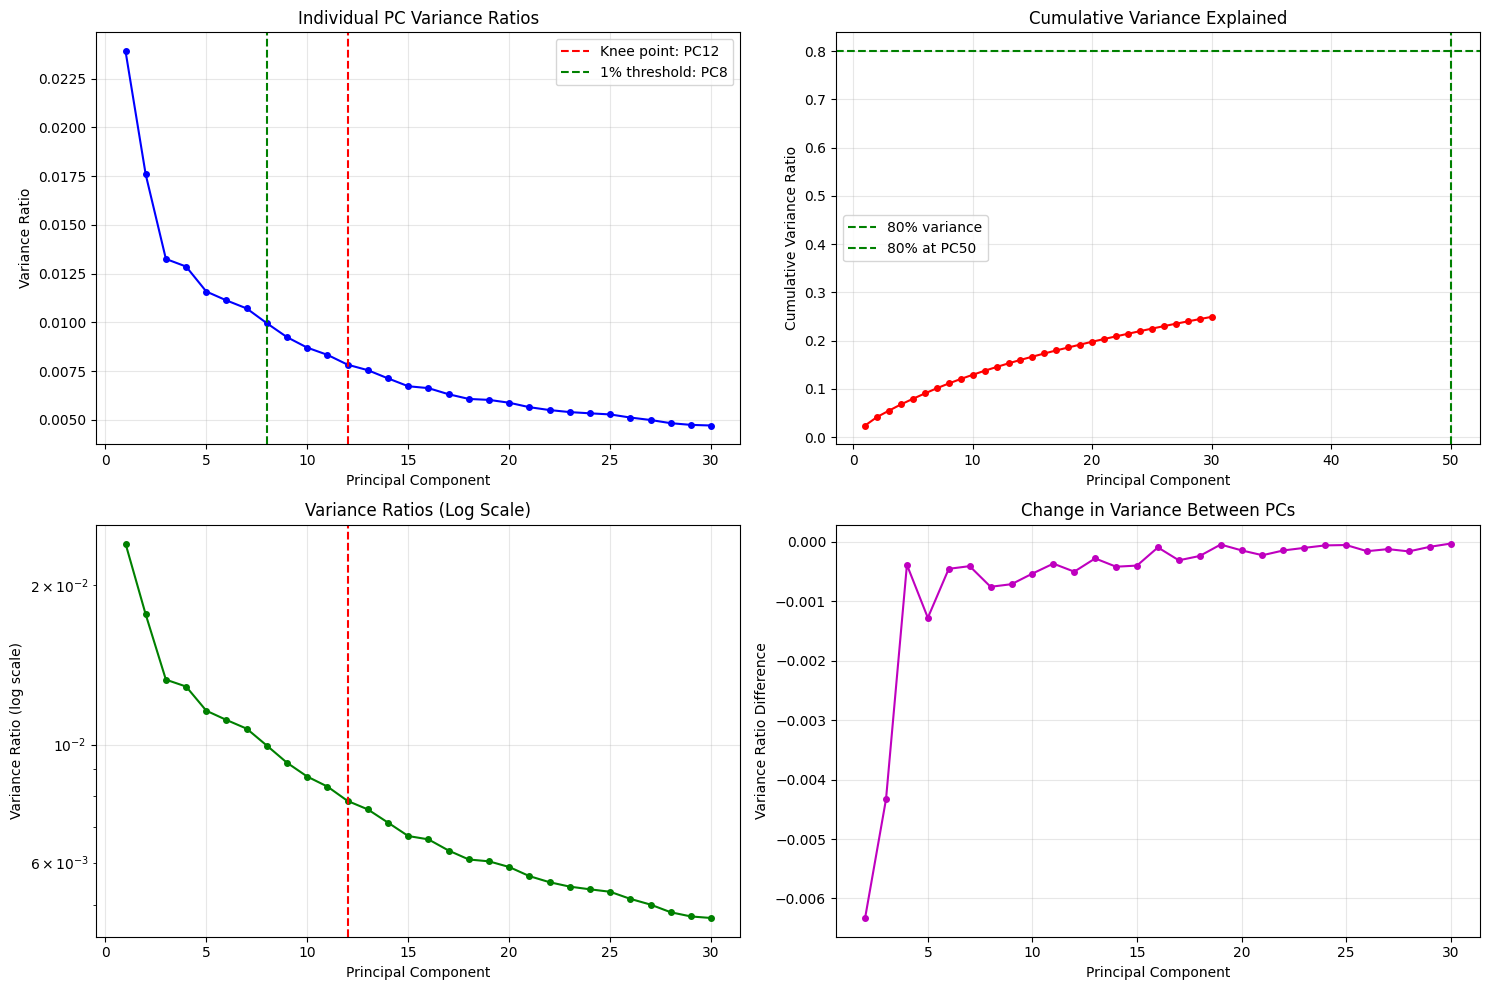


PC Selection Recommendations:
                   Method  Recommended_PCs Variance_Captured                Use_Case
     Knee Point Detection               12             14.5%         Balanced choice
  Variance Threshold (1%)                8             11.1% Remove noise components
Cumulative Variance (80%)               50             33.1%  Comprehensive analysis
      Conservative Choice                8             11.1%    Minimize overfitting
        Aggressive Choice               12             14.5%  Capture more variation

*** FINAL RECOMMENDATION: Use PC1-PC12 for downstream analysis ***
This captures 14.5% of total variance


In [20]:
# 1. Calculate cumulative variance explained
variance_ratio = adata_qc.uns['pca']['variance_ratio']
cumulative_variance = np.cumsum(variance_ratio)

# 2. Find elbow point using different methods
def find_elbow_point(variance_ratios, method='knee'):
    """Find elbow point in variance curve"""
    if method == 'knee':
        # Knee point detection
        n_components = len(variance_ratios)
        x = np.arange(n_components)
        y = variance_ratios
        
        # Line from first to last point
        line_start = np.array([x[0], y[0]])
        line_end = np.array([x[-1], y[-1]])
        
        # Calculate distances from each point to the line
        distances = []
        for i in range(n_components):
            point = np.array([x[i], y[i]])
            distance = np.abs(np.cross(line_end - line_start, line_start - point)) / np.linalg.norm(line_end - line_start)
            distances.append(distance)
        
        elbow_idx = np.argmax(distances)
        return elbow_idx + 1  # +1 because we want PC number, not index
    
    elif method == 'threshold':
        # Find where variance drops below threshold
        for i, var in enumerate(variance_ratios):
            if var < 0.01:  # 1% threshold
                return i + 1
        return len(variance_ratios)
    
    elif method == 'cumulative':
        # Find where cumulative variance reaches threshold
        cumulative = np.cumsum(variance_ratios)
        for i, cum_var in enumerate(cumulative):
            if cum_var > 0.8:  # 80% threshold
                return i + 1
        return len(variance_ratios)

# 3. Apply different elbow detection methods
elbow_knee = find_elbow_point(variance_ratio, 'knee')
elbow_threshold = find_elbow_point(variance_ratio, 'threshold')
elbow_cumulative = find_elbow_point(variance_ratio, 'cumulative')

print("=== Optimal PC Number Selection ===")
print(f"Knee point method: PC{elbow_knee}")
print(f"Variance threshold method (1%): PC{elbow_threshold}")
print(f"Cumulative variance method (80%): PC{elbow_cumulative}")

# 4. Create comprehensive elbow plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Individual variance ratios
axes[0,0].plot(range(1, 31), variance_ratio[:30], 'bo-', markersize=4)
axes[0,0].axvline(x=elbow_knee, color='red', linestyle='--', label=f'Knee point: PC{elbow_knee}')
axes[0,0].axvline(x=elbow_threshold, color='green', linestyle='--', label=f'1% threshold: PC{elbow_threshold}')
axes[0,0].set_xlabel('Principal Component')
axes[0,0].set_ylabel('Variance Ratio')
axes[0,0].set_title('Individual PC Variance Ratios')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Cumulative variance
axes[0,1].plot(range(1, 31), cumulative_variance[:30], 'ro-', markersize=4)
axes[0,1].axhline(y=0.8, color='green', linestyle='--', label='80% variance')
axes[0,1].axvline(x=elbow_cumulative, color='green', linestyle='--', label=f'80% at PC{elbow_cumulative}')
axes[0,1].set_xlabel('Principal Component')
axes[0,1].set_ylabel('Cumulative Variance Ratio')
axes[0,1].set_title('Cumulative Variance Explained')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Log scale for better visualization of tail
axes[1,0].semilogy(range(1, 31), variance_ratio[:30], 'go-', markersize=4)
axes[1,0].axvline(x=elbow_knee, color='red', linestyle='--')
axes[1,0].set_xlabel('Principal Component')
axes[1,0].set_ylabel('Variance Ratio (log scale)')
axes[1,0].set_title('Variance Ratios (Log Scale)')
axes[1,0].grid(True, alpha=0.3)

# Variance difference (second derivative approximation)
variance_diff = np.diff(variance_ratio[:30])
axes[1,1].plot(range(2, 31), variance_diff, 'mo-', markersize=4)
axes[1,1].set_xlabel('Principal Component')
axes[1,1].set_ylabel('Variance Ratio Difference')
axes[1,1].set_title('Change in Variance Between PCs')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Summary table of recommendations
pc_recommendations = pd.DataFrame({
    'Method': ['Knee Point Detection', 'Variance Threshold (1%)', 'Cumulative Variance (80%)', 
               'Conservative Choice', 'Aggressive Choice'],
    'Recommended_PCs': [elbow_knee, elbow_threshold, elbow_cumulative, 
                       min(elbow_knee, elbow_threshold), max(elbow_knee, elbow_threshold)],
    'Variance_Captured': [f"{cumulative_variance[elbow_knee-1]:.1%}", 
                         f"{cumulative_variance[elbow_threshold-1]:.1%}",
                         f"{cumulative_variance[elbow_cumulative-1]:.1%}",
                         f"{cumulative_variance[min(elbow_knee, elbow_threshold)-1]:.1%}",
                         f"{cumulative_variance[max(elbow_knee, elbow_threshold)-1]:.1%}"],
    'Use_Case': ['Balanced choice', 'Remove noise components', 'Comprehensive analysis',
                'Minimize overfitting', 'Capture more variation']
})

print("\nPC Selection Recommendations:")
print(pc_recommendations.to_string(index=False))

# 6. Final recommendation
recommended_pcs = elbow_knee
print(f"\n*** FINAL RECOMMENDATION: Use PC1-PC{recommended_pcs} for downstream analysis ***")
print(f"This captures {cumulative_variance[recommended_pcs-1]:.1%} of total variance")

# Dimensionality Reduction UMAP


/home/pissmaster/Desktop/botryllus brain analysis1/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



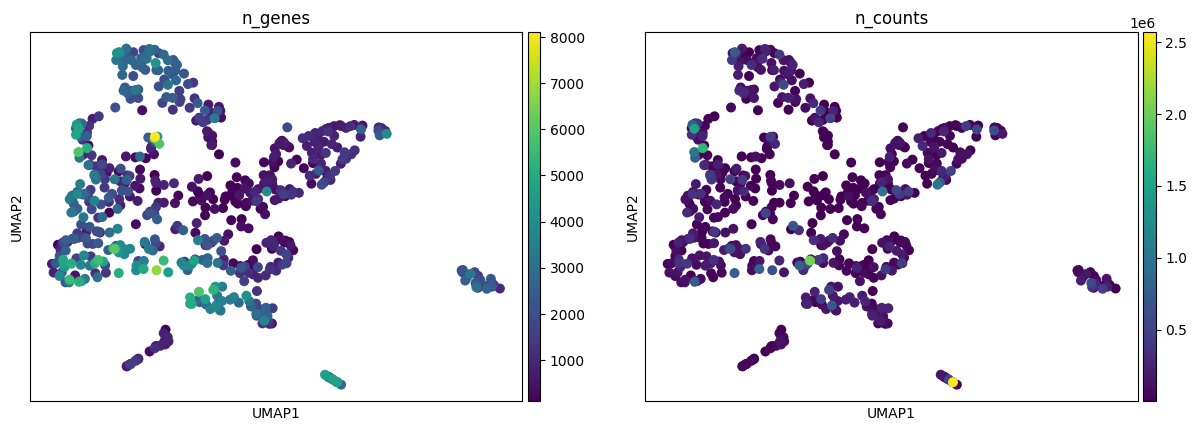

In [21]:
sc.pp.neighbors(adata_qc, n_neighbors=10, n_pcs=10)
sc.tl.umap(adata_qc)
# visualize umap based on n_genes and n_counts
sc.pl.umap(adata_qc, color=['n_genes', 'n_counts'])
# visualize umap based on sample metadata

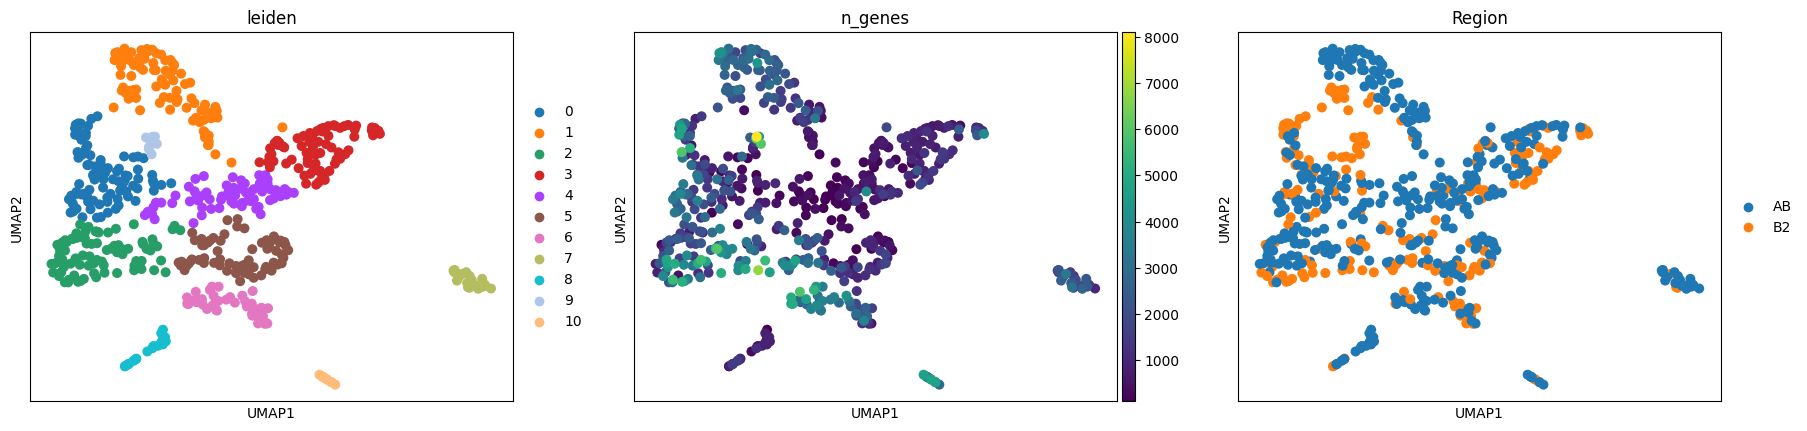

In [22]:
sc.tl.leiden(adata_qc, resolution=0.5)
sc.pl.umap(adata_qc, color=['leiden', 'n_genes', 'Region'])


In [23]:
#assign name like "leiden_0.5" to the leiden clustering
adata_qc.obs['leiden_0.5'] = adata_qc.obs['leiden']


In [24]:
sc.tl.rank_genes_groups(adata_qc, 'leiden', method='wilcoxon')


In [25]:
marker_df = sc.get.rank_genes_groups_df(adata_qc, group=None)


In [26]:
# table marker_df
print(marker_df.head())
#save marker_df to csv
marker_df.to_csv('marker_genes.csv', index=False)

  group          names     scores  logfoldchanges         pvals     pvals_adj
0     0  g20813_KLF5_2  12.114300        5.089596  8.871837e-34  1.144490e-29
1     0  g29575_g29575  12.067851        6.061803  1.561591e-33  1.144490e-29
2     0  g36792_FBN1_1  11.846194        4.994743  2.251886e-32  1.100271e-28
3     0  g26112_CR2_13  11.718459        4.503195  1.025197e-31  3.176373e-28
4     0  g29024_g29024  11.709921        5.414159  1.133856e-31  3.176373e-28


In [27]:
adata_qc = adata_qc[:, adata_qc.var.highly_variable].copy()


In [28]:
import pandas as pd
import numpy as np

# === CONFIGURATION (Publication Standards) ===
cluster_keys = ['leiden']  # Use standard 'leiden' not 'leiden_0.5'
SAVE_CSV = True
PRINT_PREVIEW = True

# Publication-quality filtering thresholds
MIN_LOGFC = 0.25        # Minimum log fold change (standard in most papers)
MAX_PVAL_ADJ = 0.05     # Adjusted p-value threshold (FDR 5%)
MIN_PCT_EXPR = 0.1      # Minimum expression percentage (10% of cells)

def clean_gene_names(gene_name):
    """Extract meaningful gene names from your g_unique format"""
    if pd.isna(gene_name):
        return gene_name
    
    parts = gene_name.split('_')
    if len(parts) > 1:
        # If it has format like g123_GENENAME, return GENENAME
        # If it has format like g123_g123, return original
        suffix = parts[1]
        if suffix.startswith('g') and suffix[1:].isdigit():
            return gene_name  # Keep original for unlabeled genes
        else:
            return suffix  # Return clean gene name
    return gene_name

# === ENHANCED MARKER GENE ANALYSIS ===
for cluster_key in cluster_keys:
    print(f"\n{'='*50}")
    print(f"MARKER GENE ANALYSIS: {cluster_key}")
    print(f"{'='*50}")
    
    # Run Wilcoxon ranking with tie correction
    sc.tl.rank_genes_groups(
        adata_qc,
        groupby=cluster_key,
        method='wilcoxon',
        tie_correct=True,
        pts=True,
        key_added=f'wilcoxon_{cluster_key}'
    )
    
    # Extract comprehensive results
    result = adata_qc.uns[f'wilcoxon_{cluster_key}']
    groups = result['names'].dtype.names
    
    # Create comprehensive marker DataFrame
    all_markers = []
    
    for group in groups:
        cluster_data = pd.DataFrame({
            'cluster': group,
            'gene_id': result['names'][group],
            'score': result['scores'][group],
            'logfoldchange': result['logfoldchanges'][group],
            'pval': result['pvals'][group],
            'pval_adj': result['pvals_adj'][group],
            'pct_expressed': result['pts'][group]
        })
        all_markers.append(cluster_data)
    
    # Combine all clusters
    marker_df = pd.concat(all_markers, ignore_index=True)
    
    # Add cleaned gene names
    marker_df['gene_name_clean'] = marker_df['gene_id'].apply(clean_gene_names)
    
    # Add significance flags
    marker_df['is_significant'] = (
        (marker_df['pval_adj'] < MAX_PVAL_ADJ) &
        (marker_df['logfoldchange'] > MIN_LOGFC) &
        (marker_df['pct_expressed'] > MIN_PCT_EXPR)
    )
    
    # Add labeled/unlabeled classification
    marker_df['is_labeled'] = ~marker_df['gene_name_clean'].str.match(r'^g\d+.*$', na=False)
    
    # Sort by cluster and score
    marker_df = marker_df.sort_values(['cluster', 'score'], ascending=[True, False])
    
    # === SUMMARY STATISTICS ===
    print(f"\nSUMMARY STATISTICS:")
    print(f"Total genes analyzed: {len(marker_df)}")
    print(f"Significant markers (logFC>{MIN_LOGFC}, FDR<{MAX_PVAL_ADJ}): {marker_df['is_significant'].sum()}")
    print(f"Labeled genes: {marker_df['is_labeled'].sum()}")
    print(f"Unlabeled genes: {(~marker_df['is_labeled']).sum()}")
    
    # Cluster-wise summary
    cluster_summary = marker_df.groupby('cluster').agg({
        'is_significant': 'sum',
        'is_labeled': 'sum',
        'score': 'max'
    }).round(3)
    cluster_summary.columns = ['Significant_Markers', 'Labeled_Genes', 'Max_Score']
    print(f"\nPer-cluster summary:")
    print(cluster_summary)
    
    # === TOP SIGNIFICANT MARKERS PER CLUSTER ===
    if PRINT_PREVIEW:
        print(f"\nTOP 5 SIGNIFICANT MARKERS PER CLUSTER:")
        for cluster in sorted(groups):
            cluster_top = marker_df[
                (marker_df['cluster'] == cluster) & 
                (marker_df['is_significant'])
            ].head(5)
            
            print(f"\nCluster {cluster} (n={len(cluster_top)} significant):")
            for _, row in cluster_top.iterrows():
                status = "LABELED" if row['is_labeled'] else "unlabeled"
                print(f"  {row['gene_name_clean']:15} | score={row['score']:6.2f} | "
                      f"logFC={row['logfoldchange']:5.2f} | pct={row['pct_expressed']:5.1%} | {status}")
    
    # === SAVE RESULTS ===
    if SAVE_CSV:
        # Save complete results
        filename_all = f'marker_genes_complete_{cluster_key}.csv'
        marker_df.to_csv(filename_all, index=False)
        
        # Save significant markers only
        sig_markers = marker_df[marker_df['is_significant']]
        filename_sig = f'marker_genes_significant_{cluster_key}.csv'
        sig_markers.to_csv(filename_sig, index=False)
        
        # Save labeled significant markers (for interpretation)
        labeled_sig = sig_markers[sig_markers['is_labeled']]
        filename_labeled = f'marker_genes_labeled_significant_{cluster_key}.csv'
        labeled_sig.to_csv(filename_labeled, index=False)
        
        print(f"\nFILES SAVED:")
        print(f"  📁 {filename_all} ({len(marker_df)} genes)")
        print(f"  📁 {filename_sig} ({len(sig_markers)} significant)")
        print(f"  📁 {filename_labeled} ({len(labeled_sig)} labeled significant)")

# === FINAL SUMMARY FOR MANUSCRIPT ===
print(f"\n{'='*60}")
print("FINAL SUMMARY FOR MANUSCRIPT")
print(f"{'='*60}")

# Create publication-ready summary
final_summary = marker_df.groupby('cluster').agg({
    'gene_id': 'count',
    'is_significant': 'sum', 
    'is_labeled': lambda x: (x & marker_df.loc[x.index, 'is_significant']).sum()
}).round()

final_summary.columns = ['Total_Genes', 'Significant_Markers', 'Labeled_Significant']
final_summary['Pct_Significant'] = (final_summary['Significant_Markers'] / final_summary['Total_Genes'] * 100).round(1)

print(final_summary)
print(f"\nDataset contains {len(adata_qc.obs)} cells across {final_summary.index.nunique()} clusters")
print(f"Average {final_summary['Significant_Markers'].mean():.1f} significant markers per cluster")
print(f"Total {final_summary['Labeled_Significant'].sum()} interpretable (labeled) markers identified")

#save top up to 100 significant markers  with corresponding score logfc pct and labeled or unlabeled per each cluster
top_markers = marker_df[marker_df['is_significant']].groupby('cluster').apply(
    lambda x: x.nlargest(100, 'score')
).reset_index(drop=True)
top_markers.to_csv('top_significant_markers_per_cluster.csv', index=False) 
print(f"\nTop significant markers saved to 'top_significant_markers_per_cluster.csv'")



MARKER GENE ANALYSIS: leiden

SUMMARY STATISTICS:
Total genes analyzed: 161238
Significant markers (logFC>0.25, FDR<0.05): 10194
Labeled genes: 76890
Unlabeled genes: 84348

Per-cluster summary:
         Significant_Markers  Labeled_Genes  Max_Score
cluster                                               
0                        738           6990  16.872999
1                       1307           6990  19.292000
10                       759           6990  22.981001
2                       3859           6990  14.642000
3                         87           6990  14.927000
4                         13           6990   8.406000
5                        231           6990  13.028000
6                       1619           6990  21.961000
7                        295           6990  20.495001
8                         19           6990  18.271000
9                       1267           6990  16.559999

TOP 5 SIGNIFICANT MARKERS PER CLUSTER:

Cluster 0 (n=5 significant):
  g12622_g12622   |

/tmp/ipykernel_166441/2388327500.py:158: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

